# Librerias

In [1]:
import os

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import xgboost as xgb
import lightgbm as lgb

In [2]:
import pickle

from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt
import shap
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns',None)

In [4]:
pd.__version__ 

'2.2.1'

In [5]:
# if pd.__version__ != "2.2.1":
#     os.system("pip install pandas==2.2.1")

# Funciones

In [6]:
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name,lag=[1]): # RS_ agregar lag
    
    assert "date" in df.columns.tolist(), "Date must be in df columns"
    
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])
    
    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample("W")[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )
    
    for i in lag:
        gb_df_[f"{new_name}_lag{i}"] = gb_df_.groupby(gb_list)[new_name].transform(lambda series: series.shift(i))
        
    
    # while i <= lag:
    #     gb_df_[f"{new_name}_ma3{i}"] = gb_df_.groupby(gb_list)[new_name].transform(lambda series: (series.rolling(window = 3).mean()).shift(i))
    #     i+=1
    print(f"Dropping columns that might cause target leakage {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)

    dfst = pd.merge(df, gb_df_, on = ["date"] + gb_list, how = "left")
    
    return dfst

In [7]:
def recuperar_fechas(df,dfo):
    unicos=dfo[["yearweek","date"]].drop_duplicates()
    df.drop(["date"], inplace = True, axis = 1)
    df=pd.merge(df,unicos, on=["yearweek"],how="left")
    return df    

In [8]:
def plot_ts_acf_pacf(y, title):
    '''
    Plots the ts you pass and the acf and pacf.
    '''
    fig = plt.figure(figsize = (12, 10))
    ax1, ax2, ax3 = fig.subplots(3, 1)

    ax1.plot(y)
    plot_acf(x = y, ax = ax2, lags = 12)
    plot_pacf(x = y, ax = ax3, lags = 12)

    plt.suptitle(t = title, fontsize = 20)

In [9]:
# def participacion_media(df,groupedweek):
    
#     df["week"]=df['date'].dt.isocalendar().week
#     df.drop(["sales_mon_fri_por_mean","sales_sat_sun_por_mean"], inplace = True, axis = 1)
#     df=pd.merge(df,groupedweek, on=["id","week"],how="left")
#     df.drop(["week"], inplace = True, axis = 1)
#     return df

In [10]:
def load_data(TRAIN_CSV_PATH):
    '''
    Loads  df.
    '''
    df = pd.read_csv(TRAIN_CSV_PATH)
    
    df["date"] = pd.to_datetime(df["date"], format = "%Y-%m-%d")

    df['month'] = df['date'].dt.month.astype("uint8")
    df['quarter'] = df['date'].dt.quarter.astype("uint16")
    df['year'] = df['date'].dt.isocalendar().year.astype("uint16")
    df["week"]=df['date'].dt.isocalendar().week.astype("uint16")
    df["item"]=df["item"].astype("uint16")
    df["category"]=df["category"].astype("uint8")
    df["department"]=df["department"].astype("uint8")
    df["store_code"]=df["store_code"].astype("uint8")
    df["region"]=df["region"].astype("uint8")
    df["event"]=df["event"].astype("uint8")
    df["event2"]=df["event2"].astype("uint8")
    df["Cantidad"]=df["Cantidad"].astype("float64")
  
    df2=df[df["Cantidad"]!=0]# creamos un dataframe sin ventas 0

    #Definimos el primer dia de venta de cada producto para luego filtrar el dataset.

    df_fechas_agregadas_por_ventas = df2.groupby(["id"]).agg (
        fecha_ult_venta = ('yearweek', 'max'),
        fecha_prim_venta = ('yearweek', 'min'),
            ).reset_index()
    
    df=pd.merge(df,df_fechas_agregadas_por_ventas[["id","fecha_prim_venta"]],how="left",on=["id"]) # llevamos el primer dia de vetna por ID al dataset principal
    df=df[df["yearweek"]>=df["fecha_prim_venta"]] #Eliminamos los registros de ventas antes del primer dia de venta.
    df.drop(columns=["fecha_prim_venta"],inplace=True)
    df.reset_index(drop=True,inplace=True)
    df.sort_values(["yearweek", "id"], ascending = True, inplace = True)
    
    sinventas_ultimoano=df_fechas_agregadas_por_ventas[df_fechas_agregadas_por_ventas["fecha_ult_venta"]<201517]["id"].to_list()
    df_prod_cont = df.loc[~df['id'].isin(sinventas_ultimoano)]
    
    semana=201316
    df_final = df_prod_cont.loc[df_prod_cont["yearweek"]>semana]
    df_final.reset_index(drop=True,inplace=True)
    df_final.sort_values(["yearweek", "id"], ascending = True, inplace = True)
    
    # NR_ROWS=df["id"].nunique()*4
    # dfho = df[:-NR_ROWS] # historical data
    # dfho["week"]=dfho['date'].dt.isocalendar().week
    # groupedweek=dfho.groupby(["id","store_code","week"]).agg({"sales_mon_fri_por":"mean","sales_sat_sun_por":"mean"}).reset_index()
    # groupedweek = groupedweek.rename(columns={'sales_mon_fri_por': 'sales_mon_fri_por_mean', 'sales_sat_sun_por': 'sales_sat_sun_por_mean'})
    
    # df["week"]=df['date'].dt.isocalendar().week
    # df=pd.merge(df,groupedweek, on=["id","store_code","week"],how="left")
    # df.drop(["week"], inplace = True, axis = 1)

    return df,df_final

def append_new_date(df, new_date, dffo):
    '''
    Appends a new row to the historical df.
    Useful to create features for train and predict.
    '''
    new_data = dffo[dffo["yearweek"]==new_date]
    df = pd.concat([df,new_data])
    df.sort_values(["id", "yearweek"], ascending = True, inplace = True)

    return df

def build_ts_features(df):
    '''
    Generates time series features.
    '''
    #df.sort_values(["id", "yearweek"], ascending = True, inplace = True)
    df_copy = df.copy(deep = True)
    # df_copy["item_sales_mean"] = df_copy.groupby(["item"])["Cantidad"].transform(lambda x: (x.mean())).astype(np.float16)
    # df_copy["revenue"]=df_copy["sell_price"]*df_copy["Cantidad"].astype("float64") 
    # df_copy["cant_diff"]=df_copy.groupby(["id"])["Cantidad"].diff()
    #df_copy["price_diff"]=df_copy.groupby(["id"])["sell_price"].diff()
    
    lags = [1,4,9]
    for lag in lags:
        df_copy["UID_sales_lag_"+str(lag)] = df_copy.groupby(["id"])["Cantidad"].shift(lag).astype("float64")
    # for lag in lags:    
    #     df_copy["UID_salesweek_lag_"+str(lag)] = df_copy.groupby(["item"])["sales_mon_fri_por_mean"].shift(lag).astype("float64")
    # for lag in lags:    
    #     df_copy["UID_saleswkd_lag_"+str(lag)] = df_copy.groupby(["item"])["sales_sat_sun_por_mean"].shift(lag).astype("float64")
    for lag in lags:
        df_copy['UID_MA_lag_{}_win_{}'.format(lag, 4)] = df_copy.groupby(["id"])['UID_sales_lag_{}'.format(lag)].transform(lambda x: x.rolling(window=4).mean()).astype(np.float64)
    for lag in lags:
        df_copy['UID_MA_lag_{}_win_{}'.format(lag, 8)] = df_copy.groupby(["id"])['UID_sales_lag_{}'.format(lag)].transform(lambda x: x.rolling(window=8).mean()).astype(np.float64)
    for lag in lags:
        df_copy['UID_MA_lag_{}_win_{}'.format(lag, 12)] = df_copy.groupby(["id"])['UID_sales_lag_{}'.format(lag)].transform(lambda x: x.rolling(window=12).mean()).astype(np.float64)
    for lag in lags:
        df_copy['UID_Mmax_lag_{}_win_{}'.format(lag, 4)] = df_copy.groupby(["id"])['UID_sales_lag_{}'.format(lag)].transform(lambda x: x.rolling(window=4).max()).astype(np.float64)
    for lag in lags:
        df_copy['UID_Mmax_lag_{}_win_{}'.format(lag, 8)] = df_copy.groupby(["id"])['UID_sales_lag_{}'.format(lag)].transform(lambda x: x.rolling(window=8).max()).astype(np.float64)
    for lag in lags:
        df_copy['UID_Mmax_lag_{}_win_{}'.format(lag, 12)] = df_copy.groupby(["id"])['UID_sales_lag_{}'.format(lag)].transform(lambda x: x.rolling(window=12).max()).astype(np.float64) 
    # for lag in lags:
    #     df_copy['UID_Mmin_lag_{}_win_{}'.format(lag, 4)] = df_copy.groupby(["id"])['UID_sales_lag_{}'.format(lag)].transform(lambda x: x.rolling(window=4).min()).astype(np.float64)
    # for lag in lags:
    #     df_copy['UID_Mmin_lag_{}_win_{}'.format(lag, 8)] = df_copy.groupby(["id"])['UID_sales_lag_{}'.format(lag)].transform(lambda x: x.rolling(window=8).min()).astype(np.float64)
    # for lag in lags:
    #     df_copy['UID_Mmin_lag_{}_win_{}'.format(lag, 12)] = df_copy.groupby(["id"])['UID_sales_lag_{}'.format(lag)].transform(lambda x: x.rolling(window=12).min()).astype(np.float64)       
    for lag in lags:
        df_copy['UID_Mstd_lag_{}_win_{}'.format(lag, 4)] = df_copy.groupby(["id"])['UID_sales_lag_{}'.format(lag)].transform(lambda x: x.rolling(window=4).std()).astype(np.float64)
    for lag in lags:
        df_copy['UID_Mstd_lag_{}_win_{}'.format(lag, 8)] = df_copy.groupby(["id"])['UID_sales_lag_{}'.format(lag)].transform(lambda x: x.rolling(window=8).std()).astype(np.float64)
    for lag in lags:
        df_copy['UID_Mstd_lag_{}_win_{}'.format(lag, 12)] = df_copy.groupby(["id"])['UID_sales_lag_{}'.format(lag)].transform(lambda x: x.rolling(window=12).std()).astype(np.float64) 

    # df_copy['sales_pct_change'] = df_copy.groupby('id')['Cantidad'].pct_change()
    # df_copy['price_pct_change'] = df_copy.groupby('id')['sell_price'].pct_change()
    # df_copy['sales_pct_change'].replace([np.inf, -np.inf], np.nan, inplace=True)
    # df_copy['price_pct_change'].replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # for lag in lags:
    #     df_copy[f"sales_pct_change_lag{lag}"] = df_copy.groupby(["id"])["sales_pct_change"].transform(lambda x: x.shift(lag))
    # for lag in lags:
    #     df_copy[f"sales_diff_lag{lag}"] = df_copy.groupby(["id"])["cant_diff"].transform(lambda x: x.shift(lag))
    # df_copy["error_MA_m"]=df_copy['UID_MA_lag_{}_win_{}'.format(lag, 4)]-df_copy["item_sales_mean"] 
    # for lag in lags:
    #     df_copy[f"price_pct_change_lag{lag}"] = df_copy.groupby(["id"])["price_pct_change"].transform(lambda x: x.shift(lag)) 
    # for lag in lags:
    #     df_copy[f"price_diff_lag{lag}"] = df_copy.groupby(["id"])["price_diff"].transform(lambda x: x.shift(lag)) 

    # df_copy["item_sales_mean"] = df_copy.groupby("item")["Cantidad"].transform("mean").astype(np.float16)
    
    # df_copy["shop_sales_mean"] = df_copy.groupby("store_code")["Cantidad"].transform("mean").astype(np.float16)

    # df_copy["dep_sales_mean"] = df_copy.groupby("department")["Cantidad"].transform("mean").astype(np.float16)
    
    # df_copy["shop_item_sales_mean"] = df_copy.groupby(["store_code","item"])["Cantidad"].transform("mean").astype(np.float16) # autorelacionada
    
    
    
    
        
    #df_copy["UID_revenue_lag_1"] = df_copy.groupby(["id"])["revenue"].shift(1).astype("float64")      
    # df_copy["item_sales_meanM"] = df_copy.groupby(["week","item"])["Cantidad"].transform(lambda x: (x.mean())).astype(np.float16)
    #df_copy["item_sales_meanM_s1"] = df_copy.groupby(["id"])["item_sales_meanM"].transform(lambda x: x.shift(1))
    # df_copy["shop_dep_sales_meanM"] = df_copy.groupby(["week","store_code","department"])["Cantidad"].transform(lambda x: (x.mean())).astype(np.float16)
    # df_copy["shop_dep_sales_meanM_s1"] = df_copy.groupby(["id"])["shop_dep_sales_meanM"].transform(lambda x: x.shift(1))
    # df_copy["shop_sales_meanM"] = df_copy.groupby(["week","store_code"])["Cantidad"].transform(lambda x: (x.mean())).astype(np.float16)
    # df_copy["shop_sales_meanM_s1"] = df_copy.groupby(["id"])["shop_sales_meanM"].transform(lambda x: x.shift(1))
    
    # df_copy['week_avg_sold'] = df_copy.groupby(['id',"week"])['Cantidad'].transform('mean').astype(np.float16)
    # df_copy['avg_sold'] = df_copy.groupby(['id'])['Cantidad'].transform('mean').astype(np.float16)
    # df_copy['selling_trend'] = (df_copy['week_avg_sold'] - df_copy['avg_sold']).astype(np.float16)

    # df_copy['expanding_sold_mean'] = df_copy.groupby(['id'])['Cantidad'].transform(lambda x: x.expanding(2).mean()).astype(np.float16)

    
    # GB_LIST = ["item"]
    # TARGET_COLUMN = "Cantidad"
    # AGG_FUNC = "sum"
    # AGG_FUNC_NAME = "SUM"
    # LAG=lags

    # df_copy = build_ts_vars(
    # df = df_copy,
    # gb_list = GB_LIST,
    # target_column = TARGET_COLUMN,
    # agg_func = AGG_FUNC,
    # agg_func_name =  AGG_FUNC_NAME,
    # lag=LAG
    # )

    # GB_LIST = ["item"]
    # TARGET_COLUMN = "Cantidad"
    # AGG_FUNC = "mean"
    # AGG_FUNC_NAME = "MEAN"
    # LAG=lags

    # df_copy = build_ts_vars(
    # df = df_copy,
    # gb_list = GB_LIST,
    # target_column = TARGET_COLUMN,
    # agg_func = AGG_FUNC,
    # agg_func_name =  AGG_FUNC_NAME,
    # lag=LAG
    # )

    # GB_LIST = ["item"]
    # TARGET_COLUMN = "Cantidad"
    # AGG_FUNC = "std"
    # AGG_FUNC_NAME = "STD"
    # LAG=lags

    # df_copy = build_ts_vars(
    # df = df_copy,
    # gb_list = GB_LIST,
    # target_column = TARGET_COLUMN,
    # agg_func = AGG_FUNC,
    # agg_func_name =  AGG_FUNC_NAME,
    # lag=LAG
    # )

    # GB_LIST = ["item"]
    # TARGET_COLUMN = "Cantidad"
    # AGG_FUNC = "min"
    # AGG_FUNC_NAME = "MIN"
    # LAG=lags

    # df_copy = build_ts_vars(
    # df = df_copy,
    # gb_list = GB_LIST,
    # target_column = TARGET_COLUMN,
    # agg_func = AGG_FUNC,
    # agg_func_name =  AGG_FUNC_NAME,
    # lag=LAG
    # )

    # GB_LIST = ["item"]
    # TARGET_COLUMN = "Cantidad"
    # AGG_FUNC = "max"
    # AGG_FUNC_NAME = "MAX"
    # LAG=lags

    # df_copy = build_ts_vars(
    # df = df_copy,
    # gb_list = GB_LIST,
    # target_column = TARGET_COLUMN,
    # agg_func = AGG_FUNC,
    # agg_func_name =  AGG_FUNC_NAME,
    # lag=LAG
    # )


    # GB_LIST = ["store_code","department"] # RS: 
    # TARGET_COLUMN = "Cantidad"
    # AGG_FUNC = "sum"
    # AGG_FUNC_NAME = "sum"
    # LAG=lags
    # df_copy = build_ts_vars(
    # df = df_copy,
    # gb_list = GB_LIST,
    # target_column = TARGET_COLUMN,
    # agg_func = AGG_FUNC,
    # agg_func_name =  AGG_FUNC_NAME,
    # lag=LAG 
    # )

    # GB_LIST = ["store_code","department"]
    # TARGET_COLUMN = "Cantidad"
    # AGG_FUNC = "min"
    # AGG_FUNC_NAME = "MIN"
    # LAG=lags

    # df_copy = build_ts_vars(
    # df = df_copy,
    # gb_list = GB_LIST,
    # target_column = TARGET_COLUMN,
    # agg_func = AGG_FUNC,
    # agg_func_name =  AGG_FUNC_NAME,
    # lag=LAG
    # )

    # GB_LIST = ["store_code","department"]
    # TARGET_COLUMN = "Cantidad"
    # AGG_FUNC = "max"
    # AGG_FUNC_NAME = "MAX"
    # LAG=lags

    # df_copy = build_ts_vars(
    # df = df_copy,
    # gb_list = GB_LIST,
    # target_column = TARGET_COLUMN,
    # agg_func = AGG_FUNC,
    # agg_func_name =  AGG_FUNC_NAME,
    # lag=LAG
    # )

    # GB_LIST = ["store_code"] # RS: 
    # TARGET_COLUMN = "Cantidad"
    # AGG_FUNC = "sum"
    # AGG_FUNC_NAME = "sum"
    # LAG=lags
    # df_copy = build_ts_vars(
    #     df = df_copy,
    #     gb_list = GB_LIST,
    #     target_column = TARGET_COLUMN,
    #     agg_func = AGG_FUNC,
    #     agg_func_name =  AGG_FUNC_NAME,
    #     lag=LAG 
    # )

    # GB_LIST = ["store_code"]
    # TARGET_COLUMN = "Cantidad"
    # AGG_FUNC = "min"
    # AGG_FUNC_NAME = "MIN"
    # LAG=lags

    # df_copy = build_ts_vars(
    # df = df_copy,
    # gb_list = GB_LIST,
    # target_column = TARGET_COLUMN,
    # agg_func = AGG_FUNC,
    # agg_func_name =  AGG_FUNC_NAME,
    # lag=LAG
    # )

    # GB_LIST = ["store_code"]
    # TARGET_COLUMN = "Cantidad"
    # AGG_FUNC = "max"
    # AGG_FUNC_NAME = "MAX"
    # LAG=lags

    # df_copy = build_ts_vars(
    # df = df_copy,
    # gb_list = GB_LIST,
    # target_column = TARGET_COLUMN,
    # agg_func = AGG_FUNC,
    # agg_func_name =  AGG_FUNC_NAME,
    # lag=LAG
    # )

    #df_copy.sort_values(["yearweek", "id"], ascending = True, inplace = True)

    COLUMNS_TO_DROP = ["date"
    ,'sales_mon_thu', 'sales_fri_sun'
    ,"sales_mon_thu_por","sales_fri_sun_por","sales_mon_thu_por_mean","sales_fri_sun_por_mean"
    # ,'week_avg_sold','avg_sold'
    # ,"item_sales_meanM"
    #"shop_dep_sales_meanM","shop_sales_meanM",
    
    #,'month', 'year'
    ,"event"
    # ,"revenue"
    # ,"cant_diff"
    #"sales_pct_change","price_pct_change","price_diff"
    #"item","store_code","region","event","week",
    #,"sell_price"
                      ]

    df_copy.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)
    df.sort_values(["id", "yearweek"], ascending = True, inplace = True)
    df_copy.set_index("id", inplace = True)

    return df_copy

def split_train_new_pred(df):
    '''
    Spits the data for traing (X_train) and features used to make 1 step ahead prediction (X_new_pred).
    '''
    train_index = sorted(list(df["yearweek"].unique()))[:-5]

    valida_index = sorted(list(df["yearweek"].unique()))[-5:-1]

    test_index = [sorted(list(df["yearweek"].unique()))[-1]]

    # print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
    # print(f"Our validation index is {valida_index}\n")
    # print(f"Our test/prediction index is {test_index}\n")

    X_train = df[df["yearweek"].isin(train_index)].drop(["Cantidad"], axis=1)
    Y_train = df[df["yearweek"].isin(train_index)]["Cantidad"]

    X_valida = df[df["yearweek"].isin(valida_index)].drop(["Cantidad"], axis=1)
    Y_valida = df[df["yearweek"].isin(valida_index)]["Cantidad"]

    X_test = df[df["yearweek"].isin(test_index)].drop(["Cantidad"], axis = 1)
    Y_test = df[df["yearweek"].isin(test_index)]["Cantidad"]
    
    return X_train, Y_train, X_valida, Y_valida , X_test , Y_test

def train_model(X_train, Y_train,X_valida,Y_valida):
    '''
    Initialize, trains and returns a trained XGBoost Regressor model.
    '''
    
    # model = xgb.XGBRegressor(eval_metric ='rmse', seed = 175)#,base_score=0)
    # model.fit(X_train, Y_train,eval_set = [(X_train, Y_train), (X_valida, Y_valida)],verbose = True,early_stopping_rounds=50)

    model = lgb.LGBMRegressor(objective='rmse', early_stopping_rounds = 10, n_estimators=1000, learning_rate=0.005)
    model.fit(X_train,  Y_train, eval_set=[(X_valida, Y_valida)], eval_metric='rmse')
    
    return model

def get_1_step_prediction(model, X_test,new_date):
    '''
    Makes 1 step ahead forecasting, and converts to a pandas DataFrame the prediction.
    '''
    y_pred = model.predict(X_test).astype("float64")
    y_pred_df=X_test.copy(deep=True)
    y_pred_df["Cantidad"] = y_pred
    y_pred_df["yearweek"]=new_date

    return y_pred_df

def get_n_step_prediction(dfh, idxf,dffo,dfo, verbose = True):
    '''
    Makes n steps ahead forecasting.
    '''
    # starting the loop
    

    resultados=[]
    x=0
           
    for new_date in idxf:
        print(new_date)
        if verbose: print(f"Working with {new_date} date.")
        # append a new date to the historical df
        dfh = append_new_date(df = dfh, new_date = new_date, dffo=dffo)
        
        if verbose: print(f"Building new featues. df shape is {dfh.shape}")
        # build time series features
        dfhf = build_ts_features(df = dfh)
        
        if verbose: print(f"Splitting data into train and prediction. df shape is {dfhf.shape}")
        # split the data between historical data an features for new predicition
        X_train, Y_train, X_valida,Y_valida ,X_test , Y_test = split_train_new_pred(dfhf)
        columnas=X_test.columns
        if verbose: print(f"Model has been trained. Making predictions")
        # train model and get predictions
        if new_date==201617:
            model = train_model(X_train = X_train, Y_train = Y_train, X_valida = X_valida, Y_valida = Y_valida)
        y_pred_df = get_1_step_prediction(model = model, X_test = X_test, new_date = new_date)

        feature_importance = model.feature_importances_
        
      
        if verbose: print(f"Appending the predictions. df shape is {dfh.shape}")
        # append new predictions to our historical df           
        y_pred_df = y_pred_df.reset_index().rename(columns={'index': 'id'})
        y_pred_df = y_pred_df.reindex(columns=dfh.columns)
        y_pred_df=recuperar_fechas(y_pred_df,dfo)
        #y_pred_df=participacion_media(y_pred_df,groupedweek)
        y_pred_df = y_pred_df.reindex(columns=dfh.columns)
        dfh=dfh[dfh["yearweek"]!=new_date]
        dfh.reset_index(drop=True,inplace=True)
        dfh = pd.concat([dfh,y_pred_df])
        dfh.sort_values(["id", "yearweek"], ascending = True, inplace = True)
        dfh.reset_index(drop=True,inplace=True)

        Y_train_predict = model.predict(X_train).astype("float64")
        Y_valida_predict = model.predict(X_valida).astype("float64")

        rmse_train = np.sqrt(
                                mean_squared_error(
                                    y_true = Y_train,
                                    y_pred = Y_train_predict
                                )
                            )

        rmse_valida = np.sqrt(
                                mean_squared_error(
                                    y_true = Y_valida,
                                    y_pred = Y_valida_predict
                                )
                            )

        rmse_train= str(round(rmse_train, 3)).replace(".", "_")
        rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")
        print(rmse_train,rmse_valida)
        
        if new_date==201617:
            Y_valida_predict = model.predict(X_valida).astype("float64")
            y_val_df=X_valida.copy(deep=True)
            y_val_df["Cantidad"] = Y_valida_predict
            y_val_df = y_val_df.reset_index().rename(columns={'index': 'id'})
            y_val_df = y_val_df.reindex(columns=dfh.columns)
            y_val_df=recuperar_fechas(y_val_df,dfo)
            y_val_df = y_val_df.reindex(columns=dfh.columns)
            a=(feature_importance,rmse_train,rmse_valida)
            resultados.append(a)
            res=pd.DataFrame(resultados,columns=["modelo","Train RMSE", "Validation RMSE"])
        if verbose: print()
        
    return dfh,y_val_df,res,columnas

def plot_predictions(dfho, dffo, title = "Normal XGBoost"):
    '''
    Plots the results: 
        for historical data (dfho), 
        future data (dffo)
        predictions (dfho.index.isin(dffo.index))
    '''
    x=dffo.set_index("date").resample("W")["Cantidad"].sum()
    y=dfho.set_index("date").resample("W")["Cantidad"].sum()
    fig = plt.figure(figsize = (12, 5))
    ax = fig.add_subplot()
    
    ax.plot(y[-59:-4], color = "blue", label = "Historical Data")
    ax.plot(x, color = "green", label = "Validation Data")
    ax.plot(y[-4:], color = "red", label = "XGBoost Predictions")
    
    plt.legend()
    plt.suptitle(title)

In [11]:
def highly_correlated(X, y, threshold):
    col_corr = list() # Set of all the names of deleted columns
    colnames = list()
    rownames = list()
    corr_matrix = X.corr().abs()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colnames.append(corr_matrix.columns[i]) # getting the name of column
                rownames.append(corr_matrix.index[j])
                col_corr.append(corr_matrix.iloc[i, j])
    Z = pd.DataFrame({'F1':colnames,
                      'F2':rownames,
                      'corr_F1_F2':col_corr,
                      'corr_F1_target': [np.abs(np.corrcoef(X[i],y)[0,1]) for i in colnames],
                      'corr_F2_target': [np.abs(np.corrcoef(X[i],y)[0,1]) for i in rownames]
                      })
    Z['F_to_delete'] = rownames
    Z['F_to_delete'][Z['corr_F1_target'] < Z['corr_F2_target']] = Z['F1'][Z['corr_F1_target'] < Z['corr_F2_target']]

    return Z

# Series Temporales

In [12]:
VERBOSE = False
CWD = os.getcwd()
DATA_PATH = os.path.join(CWD, "data")

In [13]:
dfo,dfof = load_data(TRAIN_CSV_PATH = os.path.join(DATA_PATH, "ventassem.csv"))

In [14]:
dfo["id"].nunique()

30490

In [15]:
dfof["id"].nunique()

30456

In [16]:
y = dfof.set_index('date').resample("W")["Cantidad"].sum()[:-4] # quitamos los registros de las ultimas 4 semanas

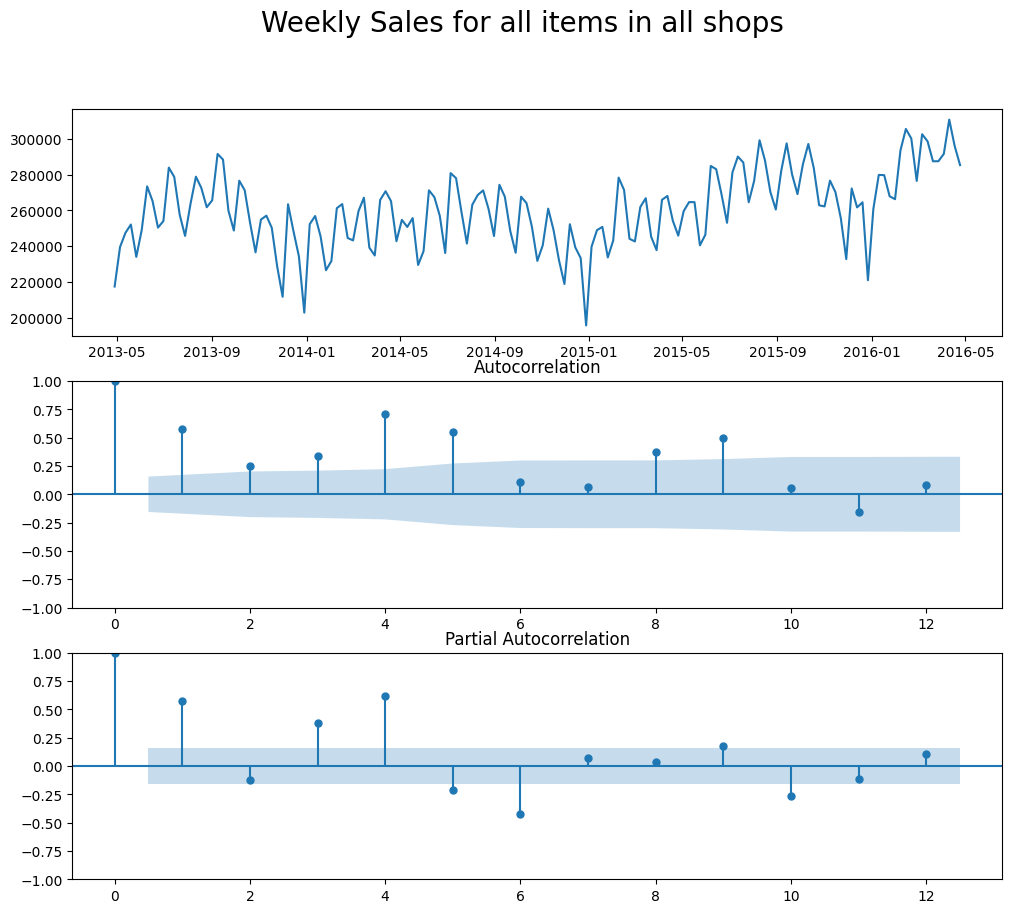

In [17]:
plot_ts_acf_pacf(y = y, title = "Weekly Sales for all items in all shops");

In [18]:
#groupedweek.head()

## Global

In [19]:
NR_ROWS=dfof["id"].nunique()*4

dfho = dfof[:-NR_ROWS] # historical data
dffo = dfof[-NR_ROWS:] # let`s imagine this is future data

idxf=dffo["yearweek"].unique().tolist()
dfho.sort_values(["id", "yearweek"], ascending = True, inplace = True)
dffo.sort_values(["id", "yearweek"], ascending = True, inplace = True)


In [20]:
dfof["category"].unique()

array([0, 1, 2], dtype=uint8)

In [21]:
region=0

In [22]:
dfhos=dfho[dfho["region"]==region]
dfhos.drop(["region"], inplace = True, axis = 1)
dffos=dffo[dffo["region"]==region]
dffos.drop(["region"], inplace = True, axis = 1)
dff0= pd.DataFrame(columns=dfof.columns)
dfv0=pd.DataFrame(columns=dfof.columns)
res0=pd.DataFrame(columns=["modelo","Train RMSE", "Validation RMSE","category"])


In [23]:
y = dfhos.set_index('date').resample("W")["Cantidad"].sum()[:-4] # quitamos los registros de las ultimas 4 semanas

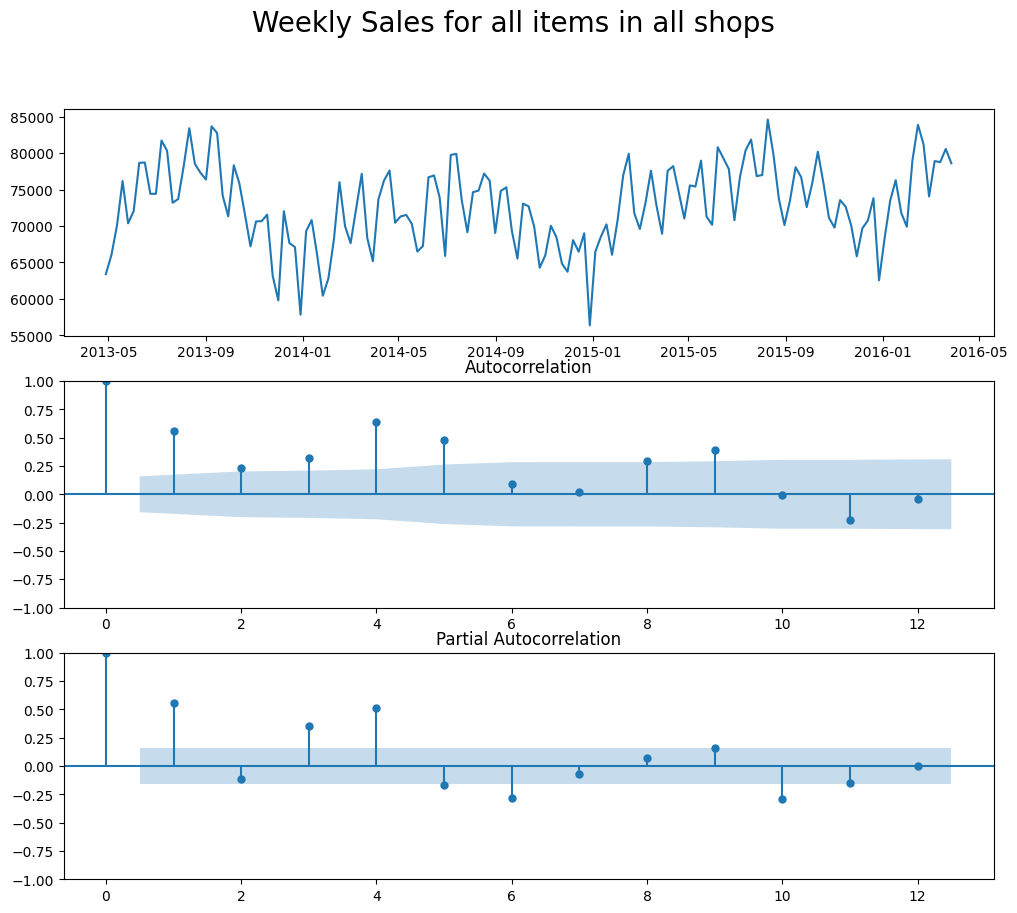

In [24]:
plot_ts_acf_pacf(y = y, title = "Weekly Sales for all items in all shops");

cat=  0
201617
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038784 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6842
[LightGBM] [Info] Number of data points in the train set: 245107, number of used features: 40
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Start training from score 4.043675
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[709]	valid_0's rmse: 3.93592
3_979 3_936
201618
3_976 3_5
201619
3_976 2_904
201620
3_977 2_026
cat=  1
201617
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Auto-choosing 

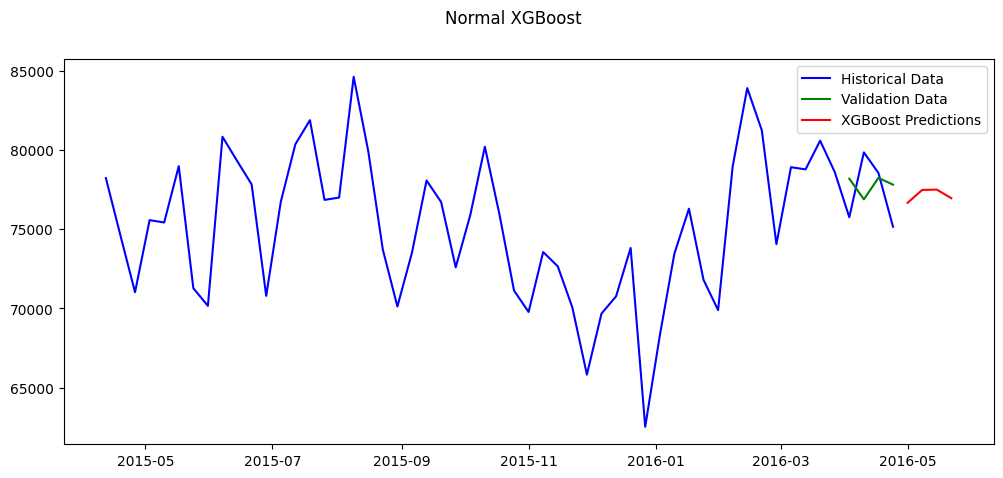

In [25]:
for cat in dfo["category"].unique().tolist():
    print("cat= ",cat) 
    dfhoc=dfhos[dfhos["category"]==cat]
    dfhoc.drop(["category"], inplace = True, axis = 1)
    dffoc=dffos[dffos["category"]==cat]
    dffoc.drop(["category"], inplace = True, axis = 1)
    dfhoc,dfvv,res,col= get_n_step_prediction(dfh = dfhoc, idxf = idxf,dffo=dffoc,dfo=dfo, verbose = VERBOSE)
    dfvv["category"]=cat
    dfhoc["category"]=cat
    res["category"]=cat
    dfhoc = dfhoc.reindex(columns=dfo.columns)
    dff0=pd.concat([dff0,dfhoc])
    dfv0=pd.concat([dfv0,dfvv])
    res0=pd.concat([res0,res])
dff0["region"]=region
dfv0["region"]=region
res0["region"]=region
#dfho.sort_values(["id", "yearweek"], ascending = True, inplace = True)
#dfhoss=recuperar_fechas(dfho,dfo)

plot_predictions(dfho =dff0, dffo = dfv0)

In [26]:
dfhoc=dfhos[dfhos["category"]==2]
dfhoc.drop(["category"], inplace = True, axis = 1)

In [27]:
y = dfhoc.set_index('date').resample("W")["Cantidad"].sum()[:-4] # quitamos los registros de las ultimas 4 semanas

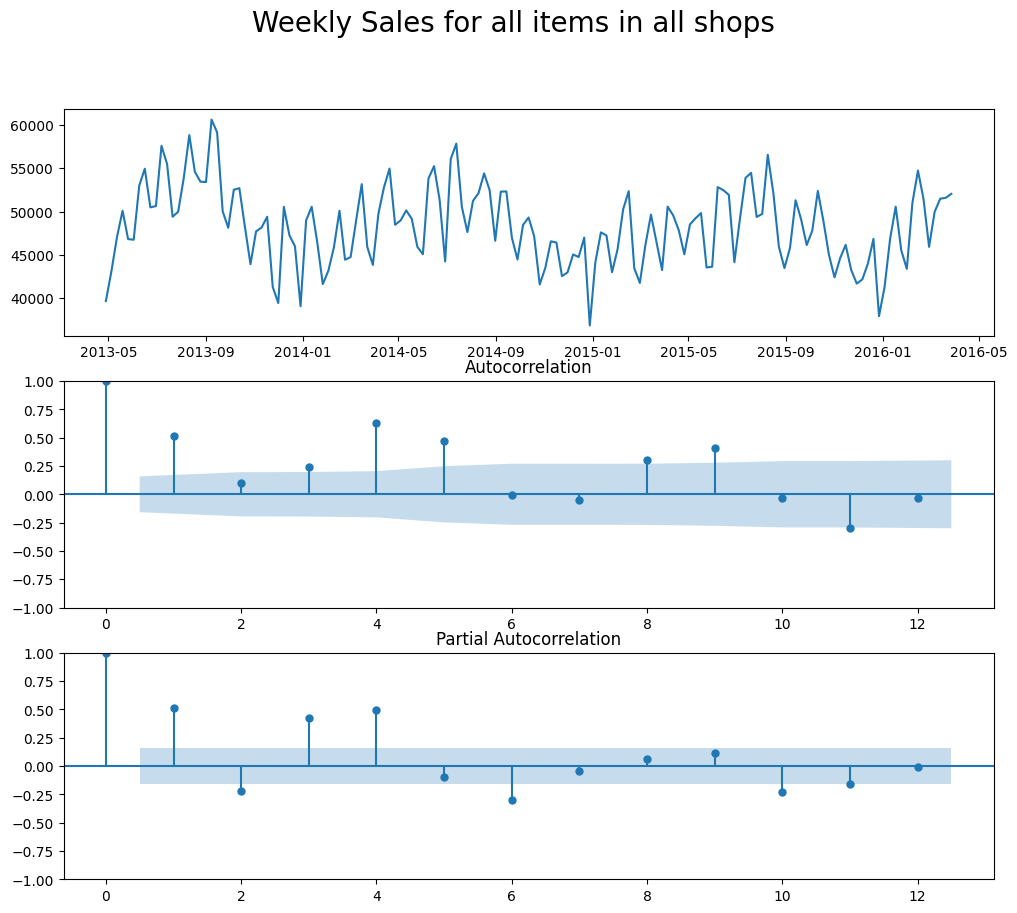

In [28]:
plot_ts_acf_pacf(y = y, title = "Weekly Sales for all items in all shops");

In [29]:
region=1

In [30]:
dfhos=dfho[dfho["region"]==region]
dfhos.drop(["region"], inplace = True, axis = 1)
dffos=dffo[dffo["region"]==region]
dffos.drop(["region"], inplace = True, axis = 1)
dff1= pd.DataFrame(columns=dfof.columns)
dfv1=pd.DataFrame(columns=dfof.columns)
res1=pd.DataFrame(columns=["modelo","Train RMSE", "Validation RMSE","category"])

cat=  0
201617
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7402
[LightGBM] [Info] Number of data points in the train set: 324956, number of used features: 40
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Start training from score 5.793741
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[691]	valid_0's rmse: 5.10503
5_298 5_105
201618
5_301 4_265
201619
5_299 3_426
201620
5_296 2_437
cat=  1
201617
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Curre

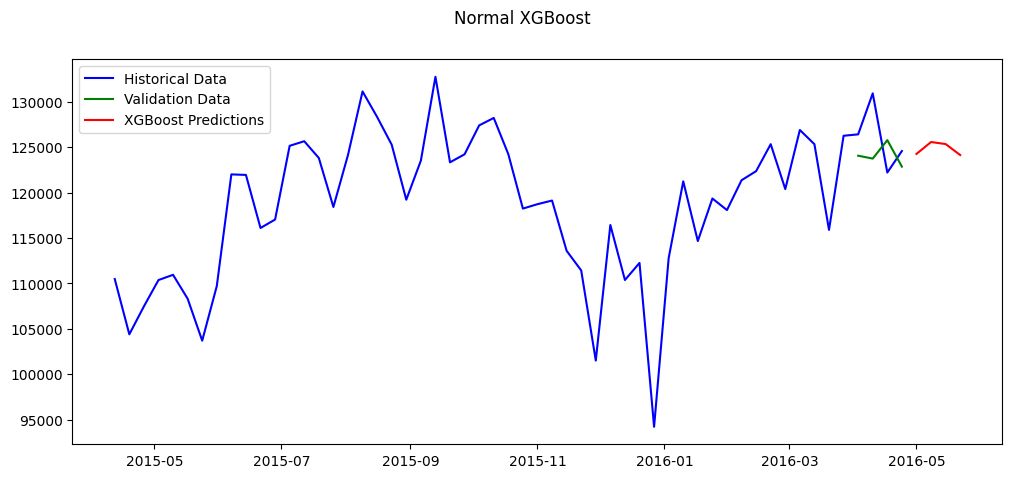

In [31]:
for cat in dfo["category"].unique().tolist():
    print("cat= ",cat) 
    dfhoc=dfhos[dfhos["category"]==cat]
    dfhoc.drop(["category"], inplace = True, axis = 1)
    dffoc=dffos[dffos["category"]==cat]
    dffoc.drop(["category"], inplace = True, axis = 1)
    dfhoc,dfvv,res,col= get_n_step_prediction(dfh = dfhoc, idxf = idxf,dffo=dffoc,dfo=dfo, verbose = VERBOSE)
    dfvv["category"]=cat
    dfhoc["category"]=cat
    res["category"]=cat
    dfhoc = dfhoc.reindex(columns=dfo.columns)
    dff1=pd.concat([dff1,dfhoc])
    dfv1=pd.concat([dfv1,dfvv])
    res1=pd.concat([res1,res])
dff1["region"]=region
dfv1["region"]=region
res1["region"]=region
#dfho.sort_values(["id", "yearweek"], ascending = True, inplace = True)
#dfhoss=recuperar_fechas(dfho,dfo)

plot_predictions(dfho =dff1, dffo = dfv1)

In [32]:
region=2

In [33]:
dfhos=dfho[dfho["region"]==region]
dfhos.drop(["region"], inplace = True, axis = 1)
dffos=dffo[dffo["region"]==region]
dffos.drop(["region"], inplace = True, axis = 1)
dff2= pd.DataFrame(columns=dfof.columns)
dfv2=pd.DataFrame(columns=dfof.columns)
res2=pd.DataFrame(columns=["modelo","Train RMSE", "Validation RMSE","category"])



cat=  0
201617
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6574
[LightGBM] [Info] Number of data points in the train set: 245767, number of used features: 40
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[LightGBM] [Info] Start training from score 3.654742
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 3.75426
3_455 3_754
201618
3_458 3_197
201619
3_459 2_646
201620
3_463 1_749
cat=  1
201617
[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be 

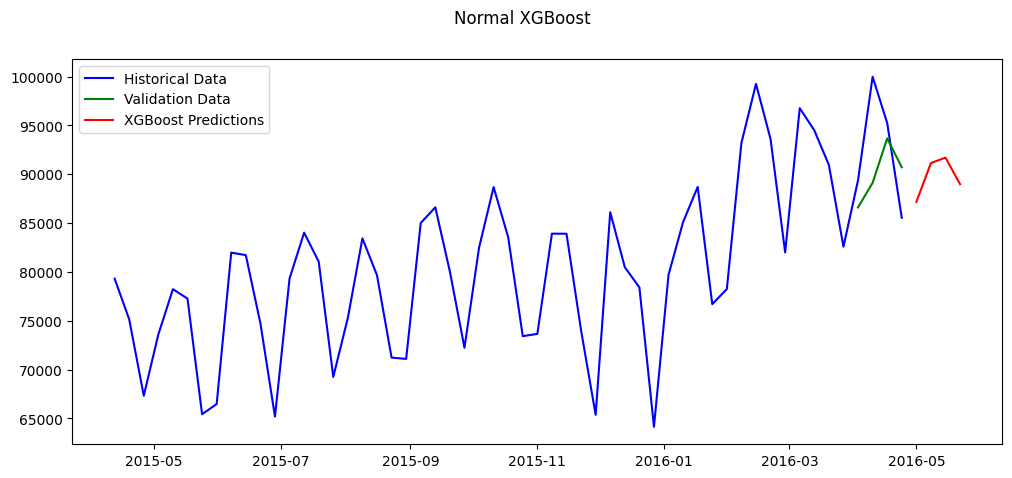

In [34]:
for cat in dfo["category"].unique().tolist():
    print("cat= ",cat) 
    dfhoc=dfhos[dfhos["category"]==cat]
    dfhoc.drop(["category"], inplace = True, axis = 1)
    dffoc=dffos[dffos["category"]==cat]
    dffoc.drop(["category"], inplace = True, axis = 1)
    dfhoc,dfvv,res,col= get_n_step_prediction(dfh = dfhoc, idxf = idxf,dffo=dffoc,dfo=dfo, verbose = VERBOSE)
    dfvv["category"]=cat
    dfhoc["category"]=cat
    res["category"]=cat
    dfhoc = dfhoc.reindex(columns=dfo.columns)
    dff2=pd.concat([dff2,dfhoc])
    dfv2=pd.concat([dfv2,dfvv])
    res2=pd.concat([res2,res])

dff2["region"]=region
dfv2["region"]=region
res2["region"]=region
#dfho.sort_values(["id", "yearweek"], ascending = True, inplace = True)
#dfhoss=recuperar_fechas(dfho,dfo)

plot_predictions(dfho =dff2, dffo = dfv2)

PARAR!!!!!!!!!!!!!!!!!!!

In [35]:
resultado=pd.concat([res0,res1,res2])

In [36]:
resultado

,modelo,Train RMSE,Validation RMSE,category,region
0,"[786, 2, 222, 1109, 1718, 17, 487, 144, 0, 0, ...",3_979,3_936,0,0
0,"[358, 135, 38, 701, 748, 15, 707, 122, 0, 0, 3...",5_426,4_683,1,0
0,"[396, 0, 35, 628, 1673, 272, 1014, 180, 0, 0, ...",11_052,7_177,2,0
0,"[632, 3, 239, 1891, 1188, 13, 775, 73, 0, 0, 4...",5_298,5_105,0,1
0,"[520, 242, 839, 1634, 1214, 140, 2057, 334, 0,...",5_084,5_052,1,1
0,"[435, 0, 114, 912, 1452, 60, 1091, 198, 0, 0, ...",12_565,8_483,2,1
0,"[766, 124, 788, 2024, 1878, 72, 1134, 130, 0, ...",3_455,3_754,0,2
0,"[203, 137, 190, 993, 695, 190, 2156, 112, 0, 0...",4_496,4_686,1,2
0,"[433, 0, 82, 1042, 1343, 10, 1435, 138, 0, 0, ...",11_964,11_615,2,2


In [44]:
resultado.iat[0,0]

array([ 786,    2,  222, 1109, 1718,   17,  487,  144,    0,    0, 4289,
        593,  328, 2465,  515,  226, 1264,  268,  353,  859,  547, 1068,
        477,  194,  149,  343,  212,  114,  271,  179,  207,  413,  216,
        230,  252,  255,  193,  102,   80,  123])

Text(0.5, 1.0, 'Feature Importance')

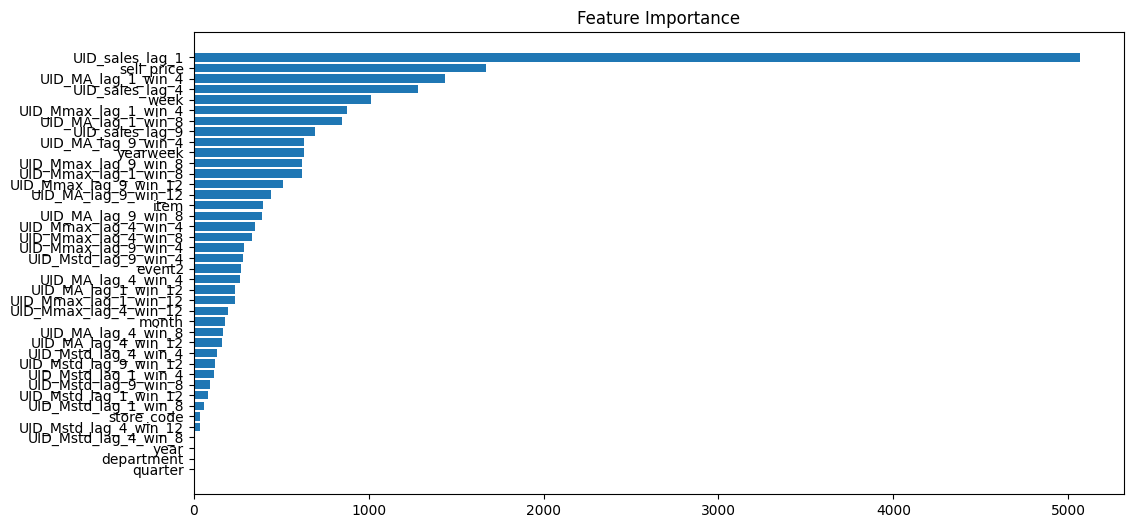

In [47]:
feature_importance = resultado.iat[2,0]
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(col)[sorted_idx])
plt.title("Feature Importance")

Text(0.5, 1.0, 'Top 5 Feature Importance')

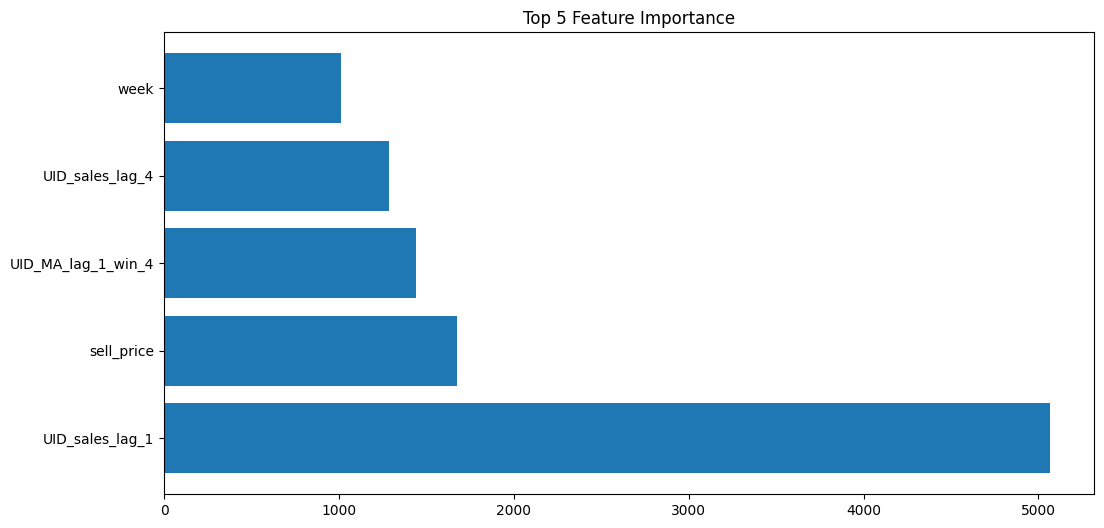

In [56]:
feature_importance = resultado.iat[2,0]
sorted_idx = np.argsort(feature_importance)[::-1]  # Invertimos el orden para que los más importantes estén primero
top_5_idx = sorted_idx[:5]  # Seleccionamos solo los primeros 5

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(top_5_idx)), feature_importance[top_5_idx], align="center")
plt.yticks(range(len(top_5_idx)), np.array(col)[top_5_idx])
plt.title("Top 5 Feature Importance")

In [48]:
dfv=pd.concat([dfv0,dfv1,dfv2])

In [49]:
dff=pd.concat([dff0,dff1,dff2])

In [50]:
y = dfv.set_index('date').resample("W")["Cantidad"].sum() # quitamos los registros de las ultimas 4 semanas

In [51]:
y

date
2016-04-03    288862.823686
2016-04-10    289760.156370
2016-04-17    297688.209812
2016-04-24    291391.752506
Freq: W-SUN, Name: Cantidad, dtype: float64

In [ ]:
y = dff.set_index('date').resample("W")["Cantidad"].sum() # quitamos los registros de las ultimas 4 semanas

In [ ]:
y[-8:-4]

In [ ]:
plot_predictions(dfho =dff, dffo = dfv)

In [ ]:
dfv=dfv.rename(columns={"Cantidad":"Valid"})

In [ ]:
dff=pd.merge(dff,dfv[["id","yearweek","Valid"]],how="left",on=["id","yearweek"])

In [ ]:
Y_valid_total=dff[(dff["yearweek"]>201612)&(dff["yearweek"]<201617)]["Cantidad"]

In [ ]:
Y_valid_total.min()

In [ ]:
Y_valid_pred=dff[(dff["yearweek"]>201612)&(dff["yearweek"]<201617)]["Valid"]

In [ ]:
Y_valid_pred.min()

In [ ]:
rmse_valida = np.sqrt(
                                mean_squared_error(
                                    y_true = Y_valid_total,
                                    y_pred = Y_valid_pred
                                )
                            )

In [ ]:
rmse_valida

In [ ]:
from pathlib import Path  
filepath = Path("data/pred.csv")  
filepath.parent.mkdir(parents=True, exist_ok=True)  
dff.to_csv(filepath,index=False)  

In [ ]:
from pathlib import Path  
filepath = Path("data/val.csv")  
filepath.parent.mkdir(parents=True, exist_ok=True)  
dfv.to_csv(filepath,index=False)  

In [ ]:
dff=pd.read_csv("data/pred.csv")

In [ ]:
dfv=pd.read_csv("data/val.csv")

In [ ]:
dff["date"]=pd.to_datetime(dff["date"])
dfv["date"]=pd.to_datetime(dfv["date"])

In [ ]:

sample1=dff["id"].sample().item()
t1=dff[dff["id"]==sample1]
t2=dfv[dfv["id"]==sample1]
plot_predictions(dfho =t1, dffo = t2,title=sample1)

In [ ]:

sample1=dff["id"].sample().item()
t1=dff[dff["id"]==sample1]
t2=dfv[dfv["id"]==sample1]
plot_predictions(dfho =t1, dffo = t2,title=sample1)

In [ ]:
sample1=dff["id"].sample().item()
t1=dff[dff["id"]==sample1]
t2=dfv[dfv["id"]==sample1]
plot_predictions(dfho =t1, dffo = t2,title=sample1)

In [ ]:
y=dff.set_index("date").resample("W")["Cantidad"].sum()
y[-57:]

In [ ]:
x=dfv.set_index("date").resample("W")["Cantidad"].sum()
x

In [ ]:
plot_predictions(dfho =dff, dffo = dfv)

Prueba Paso a Paso

In [ ]:
R_ROWS=dfof["id"].nunique()*4

dfho = dfof[:-NR_ROWS] # historical data
dffo = dfof[-NR_ROWS:] # let`s imagine this is future data

idxf=dffo["yearweek"].unique().tolist()
dfho.sort_values(["id", "yearweek"], ascending = True, inplace = True)
dffo.sort_values(["id", "yearweek"], ascending = True, inplace = True)

In [ ]:
region=0

In [ ]:
dfhos=dfho[dfho["region"]==region]
dfhos.drop(["region"], inplace = True, axis = 1)
dffos=dffo[dffo["region"]==region]
dffos.drop(["region"], inplace = True, axis = 1)
dff0= pd.DataFrame(columns=dfof.columns)
dfv0=pd.DataFrame(columns=dfof.columns)
res0=pd.DataFrame(columns=["modelo","Train RMSE", "Validation RMSE","category"])


In [ ]:
dffos.head()

In [ ]:
cat=0

In [ ]:
print("cat= ",cat) 
dfhoc=dfhos[dfhos["category"]==cat]
dfhoc.drop(["category"], inplace = True, axis = 1)
dffoc=dffos[dffos["category"]==cat]
dffoc.drop(["category"], inplace = True, axis = 1)

In [ ]:
dfhoc.head()

In [ ]:
new_date=201617

In [ ]:
new_data = dffoc[dffoc["yearweek"]==new_date]
dfh = pd.concat([dfhoc,new_data])
dfh.sort_values(["id", "yearweek"], ascending = True, inplace = True)

In [ ]:
dfhf = build_ts_features(df = dfh)

In [ ]:
dfhf.tail()

In [ ]:
X_train, Y_train, X_valida,Y_valida ,X_test , Y_test = split_train_new_pred(dfhf)

In [ ]:
model = train_model(X_train = X_train, Y_train = Y_train, X_valida = X_valida, Y_valida = Y_valida)

In [ ]:
y_pred_df = get_1_step_prediction(model = model, X_test = X_test, new_date = new_date)

In [ ]:
y_pred_df.head()

In [ ]:
y_pred_df = y_pred_df.reset_index().rename(columns={'index': 'id'})
y_pred_df = y_pred_df.reindex(columns=dfh.columns)
y_pred_df=recuperar_fechas(y_pred_df,dfo)

In [ ]:
#y_pred_df=participacion_media(y_pred_df,groupedweek)
y_pred_df = y_pred_df.reindex(columns=dfh.columns)
dfh=dfh[dfh["yearweek"]!=new_date]
dfh.reset_index(drop=True,inplace=True)
dfh = pd.concat([dfh,y_pred_df])
dfh.sort_values(["id", "yearweek"], ascending = True, inplace = True)
dfh.reset_index(drop=True,inplace=True)

In [ ]:
y_pred_df["Cantidad"].sum()

In [ ]:
new_date=201617

In [ ]:
dffo.head()

In [ ]:
new_data = dffo[dffo["yearweek"]==new_date]

In [ ]:
new_data.head()

In [ ]:
dfho.shape

In [ ]:
dfho.head()

In [ ]:
new_data.shape

In [ ]:
dfh = pd.concat([dfho,new_data])

In [ ]:
dfh.sort_values(["item", "yearweek"], ascending = True, inplace = True)

In [ ]:
dfh.shape

In [ ]:
dfh.tail()

In [ ]:
#dfh.sort_values(["id", "yearweek"], ascending = True, inplace = True)

In [ ]:
df_copy = dfh.copy(deep = True)

In [ ]:
lags = [1,2,3]
for lag in lags:
    df_copy["UID_sales_lag_"+str(lag)] = df_copy.groupby(["item"])["Cantidad"].shift(lag).astype("float64")
# for lag in lags:    
#     df_copy["UID_salesweek_lag_"+str(lag)] = df_copy.groupby(["item"])["sales_mon_fri_por_mean"].shift(lag).astype("float64")
# for lag in lags:    
#     df_copy["UID_saleswkd_lag_"+str(lag)] = df_copy.groupby(["item"])["sales_sat_sun_por_mean"].shift(lag).astype("float64")

In [ ]:
df_copy.head()

In [ ]:
GB_LIST = ["department"]
TARGET_COLUMN = "Cantidad"
AGG_FUNC = "sum"
AGG_FUNC_NAME = "SUM"
LAG=1

df_copy = build_ts_vars(
df = df_copy,
gb_list = GB_LIST,
target_column = TARGET_COLUMN,
agg_func = AGG_FUNC,
agg_func_name =  AGG_FUNC_NAME,
lag=LAG
)

GB_LIST = ["category","department"] # RS: 
TARGET_COLUMN = "Cantidad"
AGG_FUNC = "sum"
AGG_FUNC_NAME = "sum"
LAG=1
df_copy = build_ts_vars(
df = df_copy,
gb_list = GB_LIST,
target_column = TARGET_COLUMN,
agg_func = AGG_FUNC,
agg_func_name =  AGG_FUNC_NAME,
lag=LAG 
)

GB_LIST = ["category"] # RS: 
TARGET_COLUMN = "Cantidad"
AGG_FUNC = "sum"
AGG_FUNC_NAME = "sum"
LAG=1
df_copy = build_ts_vars(
    df = df_copy,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME,
    lag=LAG 
)

In [ ]:
#df_copy.sort_values(["yearweek", "id"], ascending = True, inplace = True)

In [ ]:
COLUMNS_TO_DROP = ["date"
    ,'sales_mon_fri', 'sales_sat_sun'
    ,"sales_mon_fri_por","sales_sat_sun_por"
    #,"sales_mon_fri_por_mean","sales_sat_sun_por_mean"
    ,'month', 'year'
    #"item","store_code","region","event","week",
    #,"sell_price"
                      ]

df_copy.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [ ]:
df_copy.head()

In [ ]:
df_copy.set_index("item", inplace = True)

In [ ]:
dfhf=df_copy.copy(deep = True)

In [ ]:
dfhf.tail()

In [ ]:
train_index = sorted(list(dfhf["yearweek"].unique()))[:-5]

valida_index = sorted(list(dfhf["yearweek"].unique()))[-5:-1]

test_index = [sorted(list(dfhf["yearweek"].unique()))[-1]]

print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
print(f"Our validation index is {valida_index}\n")
print(f"Our test/prediction index is {test_index}\n")

X_train = dfhf[dfhf["yearweek"].isin(train_index)].drop(["Cantidad", "yearweek"], axis=1)
Y_train = dfhf[dfhf["yearweek"].isin(train_index)]["Cantidad"]

X_valida = dfhf[dfhf["yearweek"].isin(valida_index)].drop(["Cantidad", "yearweek"], axis=1)
Y_valida = dfhf[dfhf["yearweek"].isin(valida_index)]["Cantidad"]

X_test = dfhf[dfhf["yearweek"].isin(test_index)].drop(["Cantidad", "yearweek"], axis = 1)
Y_test = dfhf[dfhf["yearweek"].isin(test_index)]["Cantidad"]

In [ ]:
X_train.tail()

In [ ]:
X_valida.shape

In [ ]:
X_test.shape

In [ ]:
Y_train.sum()

In [ ]:
Y_valida.sum()

In [ ]:
Y_test.sum()

In [ ]:
Y_train.sum()+Y_valida.sum()

In [ ]:
model = xgb.XGBRegressor(eval_metric ='rmse', seed = 175)#,base_score=0)

In [ ]:
model.fit(X_train, Y_train,eval_set = [(X_train, Y_train), (X_valida, Y_valida)],verbose = True,early_stopping_rounds=50)


In [ ]:
y_pred = model.predict(X_test).astype("float64")

In [ ]:
Y_valida_predict = model.predict(X_valida).astype("float64")

In [ ]:
Y_train_predict = model.predict(X_train).astype("float64")

In [ ]:
rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

In [ ]:
resultados=[]

In [ ]:
print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

In [ ]:
a=(new_date,rmse_train,rmse_valida)

In [ ]:
resultados.append(a)

In [ ]:
resultados

In [ ]:
ab=pd.DataFrame(resultados,columns=["modelo","Train RMSE", "Validation RMSE"])

In [ ]:
ab

In [ ]:
y_pred.sum()

In [ ]:
y_pred_df=X_test.copy(deep=True)

In [ ]:
y_pred_df["Cantidad"] = y_pred

In [ ]:
y_pred_df["yearweek"]=new_date

In [ ]:
y_pred_df.describe().T

In [ ]:
y_pred_df.head()

In [ ]:
y_pred_df = y_pred_df.reset_index().rename(columns={'index': 'item'})

In [ ]:
y_pred_df = y_pred_df.reindex(columns=dfh.columns)

In [ ]:
y_pred_df=recuperar_fechas(y_pred_df,dfo)

In [ ]:
y_pred_df=participacion_media(y_pred_df,groupedweeks)

In [ ]:
y_pred_df.head()

In [ ]:
y_pred_df = y_pred_df.reindex(columns=dfh.columns)

In [ ]:
y_pred_df.head()

In [ ]:
dfh=dfh[dfh["yearweek"]!=new_date]

In [ ]:
dfh.reset_index(drop=True,inplace=True)

In [ ]:
dfh[dfh["yearweek"]!=new_date]["Cantidad"].sum()

In [ ]:
dfh = pd.concat([dfh,y_pred_df])

In [ ]:
(dfh["Cantidad"].sum())-y_pred.sum()

In [ ]:
dfh.reset_index(drop=True,inplace=True)

In [ ]:
dfh.tail(10)

In [ ]:
dff= pd.DataFrame(columns=dfo.columns)
resu=pd.DataFrame(columns=["modelo","Train RMSE", "Validation RMSE","store"])

In [ ]:
new_date=201618

In [ ]:
dffo.head()

In [ ]:
new_data = dffo[dffo["yearweek"]==new_date]

In [ ]:
new_data.head()

In [ ]:
dfh.shape

In [ ]:
dfh.head()

In [ ]:
new_data.shape

In [ ]:
dfh = pd.concat([dfh,new_data])

In [ ]:
dfh.sort_values(["item", "yearweek"], ascending = True, inplace = True)

In [ ]:
dfh.shape

In [ ]:
dfh.tail()

In [ ]:
#dfh.sort_values(["id", "yearweek"], ascending = True, inplace = True)

In [ ]:
df_copy = dfh.copy(deep = True)

In [ ]:
lags = [1,2,3]
for lag in lags:
    df_copy["UID_sales_lag_"+str(lag)] = df_copy.groupby(["item"])["Cantidad"].shift(lag).astype("float64")
for lag in lags:    
    df_copy["UID_salesweek_lag_"+str(lag)] = df_copy.groupby(["item"])["sales_mon_fri_por_mean"].shift(lag).astype("float64")
for lag in lags:    
    df_copy["UID_saleswkd_lag_"+str(lag)] = df_copy.groupby(["item"])["sales_sat_sun_por_mean"].shift(lag).astype("float64")

In [ ]:
df_copy.head()

In [ ]:
GB_LIST = ["department"]
TARGET_COLUMN = "Cantidad"
AGG_FUNC = "sum"
AGG_FUNC_NAME = "SUM"
LAG=1

df_copy = build_ts_vars(
df = df_copy,
gb_list = GB_LIST,
target_column = TARGET_COLUMN,
agg_func = AGG_FUNC,
agg_func_name =  AGG_FUNC_NAME,
lag=LAG
)

GB_LIST = ["category","department"] # RS: 
TARGET_COLUMN = "Cantidad"
AGG_FUNC = "sum"
AGG_FUNC_NAME = "sum"
LAG=1
df_copy = build_ts_vars(
df = df_copy,
gb_list = GB_LIST,
target_column = TARGET_COLUMN,
agg_func = AGG_FUNC,
agg_func_name =  AGG_FUNC_NAME,
lag=LAG 
)

GB_LIST = ["category"] # RS: 
TARGET_COLUMN = "Cantidad"
AGG_FUNC = "sum"
AGG_FUNC_NAME = "sum"
LAG=1
df_copy = build_ts_vars(
    df = df_copy,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME,
    lag=LAG 
)

In [ ]:
#df_copy.sort_values(["yearweek", "id"], ascending = True, inplace = True)

In [ ]:
COLUMNS_TO_DROP = ["date"
    ,'sales_mon_fri', 'sales_sat_sun'
    ,"sales_mon_fri_por","sales_sat_sun_por"
    ,"sales_mon_fri_por_mean","sales_sat_sun_por_mean" 
    ,'month', 'year'
    #"item","store_code","region","event","week",
    #,"sell_price"
                      ]

df_copy.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [ ]:
df_copy.head()

In [ ]:
df_copy.set_index("item", inplace = True)

In [ ]:
dfhf=df_copy.copy(deep = True)

In [ ]:
train_index = sorted(list(dfhf["yearweek"].unique()))[:-2]

valida_index = [sorted(list(dfhf["yearweek"].unique()))[-2]]

test_index = [sorted(list(dfhf["yearweek"].unique()))[-1]]

# print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
# print(f"Our validation index is {valida_index}\n")
# print(f"Our test/prediction index is {test_index}\n")

X_train = dfhf[dfhf["yearweek"].isin(train_index)].drop(["Cantidad", "yearweek"], axis=1)
Y_train = dfhf[dfhf["yearweek"].isin(train_index)]["Cantidad"]

X_valida = dfhf[dfhf["yearweek"].isin(valida_index)].drop(["Cantidad", "yearweek"], axis=1)
Y_valida = dfhf[dfhf["yearweek"].isin(valida_index)]["Cantidad"]

X_test = dfhf[dfhf["yearweek"].isin(test_index)].drop(["Cantidad", "yearweek"], axis = 1)
Y_test = dfhf[dfhf["yearweek"].isin(test_index)]["Cantidad"]

In [ ]:
X_train.shape

In [ ]:
X_valida.shape

In [ ]:
X_test.shape

In [ ]:
Y_train.sum()

In [ ]:
Y_valida.sum()

In [ ]:
Y_test.sum()

In [ ]:
Y_train.sum()+Y_valida.sum()

In [ ]:
model = xgb.XGBRegressor(eval_metric ='rmse', seed = 175)#,base_score=0)

In [ ]:
model.fit(X_train, Y_train,eval_set = [(X_train, Y_train), (X_valida, Y_valida)],verbose = True,early_stopping_rounds=50)


In [ ]:
y_pred = model.predict(X_test).astype("float64")

In [ ]:
Y_valida_predict = model.predict(X_valida).astype("float64")

In [ ]:
Y_train_predict = model.predict(X_train).astype("float64")

In [ ]:
rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

In [ ]:
print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

In [ ]:
a=(new_date,rmse_train,rmse_valida)

In [ ]:
resultados.append(a)

In [ ]:
resultados

In [ ]:
ab=pd.DataFrame(resultados,columns=["modelo","Train RMSE", "Validation RMSE"])

In [ ]:
ab

In [ ]:
y_pred.sum()

In [ ]:
y_pred_df=X_test.copy(deep=True)

In [ ]:
y_pred_df["Cantidad"] = y_pred

In [ ]:
y_pred_df["yearweek"]=new_date

In [ ]:
y_pred_df.describe().T

In [ ]:
y_pred_df.head()

In [ ]:
y_pred_df = y_pred_df.reset_index().rename(columns={'index': 'item'})

In [ ]:
y_pred_df = y_pred_df.reindex(columns=dfh.columns)

In [ ]:
y_pred_df=recuperar_fechas(y_pred_df,dfo)

In [ ]:
y_pred_df=participacion_media(y_pred_df,groupedweeks)

In [ ]:
y_pred_df.head()

In [ ]:
y_pred_df = y_pred_df.reindex(columns=dfh.columns)

In [ ]:
y_pred_df.head()

In [ ]:
dfh=dfh[dfh["yearweek"]!=new_date]

In [ ]:
dfh.reset_index(drop=True,inplace=True)

In [ ]:
dfh[dfh["yearweek"]!=new_date]["Cantidad"].sum()

In [ ]:
dfh = pd.concat([dfh,y_pred_df])

In [ ]:
(dfh["Cantidad"].sum())-y_pred.sum()

In [ ]:
dfh.reset_index(drop=True,inplace=True)

In [ ]:
dfh.tail(10)

In [ ]:
new_date=201619

In [ ]:
dffo.head()

In [ ]:
new_data = dffo[dffo["yearweek"]==new_date]

In [ ]:
new_data.head()

In [ ]:
dfh.shape

In [ ]:
dfh.head()

In [ ]:
new_data.shape

In [ ]:
dfh = pd.concat([dfh,new_data])

In [ ]:
dfh.sort_values(["item", "yearweek"], ascending = True, inplace = True)

In [ ]:
dfh.shape

In [ ]:
dfh.tail()

In [ ]:
#dfh.sort_values(["id", "yearweek"], ascending = True, inplace = True)

In [ ]:
df_copy = dfh.copy(deep = True)

In [ ]:
lags = [1,2,3]
for lag in lags:
    df_copy["UID_sales_lag_"+str(lag)] = df_copy.groupby(["item"])["Cantidad"].shift(lag).astype("float64")
for lag in lags:    
    df_copy["UID_salesweek_lag_"+str(lag)] = df_copy.groupby(["item"])["sales_mon_fri_por_mean"].shift(lag).astype("float64")
for lag in lags:    
    df_copy["UID_saleswkd_lag_"+str(lag)] = df_copy.groupby(["item"])["sales_sat_sun_por_mean"].shift(lag).astype("float64")

In [ ]:
df_copy.head()

In [ ]:
GB_LIST = ["department"]
TARGET_COLUMN = "Cantidad"
AGG_FUNC = "sum"
AGG_FUNC_NAME = "SUM"
LAG=1

df_copy = build_ts_vars(
df = df_copy,
gb_list = GB_LIST,
target_column = TARGET_COLUMN,
agg_func = AGG_FUNC,
agg_func_name =  AGG_FUNC_NAME,
lag=LAG
)

GB_LIST = ["category","department"] # RS: 
TARGET_COLUMN = "Cantidad"
AGG_FUNC = "sum"
AGG_FUNC_NAME = "sum"
LAG=1
df_copy = build_ts_vars(
df = df_copy,
gb_list = GB_LIST,
target_column = TARGET_COLUMN,
agg_func = AGG_FUNC,
agg_func_name =  AGG_FUNC_NAME,
lag=LAG 
)

GB_LIST = ["category"] # RS: 
TARGET_COLUMN = "Cantidad"
AGG_FUNC = "sum"
AGG_FUNC_NAME = "sum"
LAG=1
df_copy = build_ts_vars(
    df = df_copy,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME,
    lag=LAG 
)

In [ ]:
#df_copy.sort_values(["yearweek", "id"], ascending = True, inplace = True)

In [ ]:
COLUMNS_TO_DROP = ["date"
    ,'sales_mon_fri', 'sales_sat_sun'
    ,"sales_mon_fri_por","sales_sat_sun_por"
    ,"sales_mon_fri_por_mean","sales_sat_sun_por_mean"
    ,'month', 'year'
    #"item","store_code","region","event","week",
    #,"sell_price"
                      ]

df_copy.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [ ]:
df_copy.head()

In [ ]:
df_copy.set_index("item", inplace = True)

In [ ]:
dfhf=df_copy.copy(deep = True)

In [ ]:
train_index = sorted(list(dfhf["yearweek"].unique()))[:-2]

valida_index = [sorted(list(dfhf["yearweek"].unique()))[-2]]

test_index = [sorted(list(dfhf["yearweek"].unique()))[-1]]

# print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
# print(f"Our validation index is {valida_index}\n")
# print(f"Our test/prediction index is {test_index}\n")

X_train = dfhf[dfhf["yearweek"].isin(train_index)].drop(["Cantidad", "yearweek"], axis=1)
Y_train = dfhf[dfhf["yearweek"].isin(train_index)]["Cantidad"]

X_valida = dfhf[dfhf["yearweek"].isin(valida_index)].drop(["Cantidad", "yearweek"], axis=1)
Y_valida = dfhf[dfhf["yearweek"].isin(valida_index)]["Cantidad"]

X_test = dfhf[dfhf["yearweek"].isin(test_index)].drop(["Cantidad", "yearweek"], axis = 1)
Y_test = dfhf[dfhf["yearweek"].isin(test_index)]["Cantidad"]

In [ ]:
X_train.shape

In [ ]:
X_valida.shape

In [ ]:
X_test.shape

In [ ]:
Y_train.sum()

In [ ]:
Y_valida.sum()

In [ ]:
Y_test.sum()

In [ ]:
Y_train.sum()+Y_valida.sum()

In [ ]:
model = xgb.XGBRegressor(eval_metric ='rmse', seed = 175)#,base_score=0)

In [ ]:
model.fit(X_train, Y_train,eval_set = [(X_train, Y_train), (X_valida, Y_valida)],verbose = True,early_stopping_rounds=50)


In [ ]:
y_pred = model.predict(X_test).astype("float64")

In [ ]:
Y_valida_predict = model.predict(X_valida).astype("float64")

In [ ]:
Y_train_predict = model.predict(X_train).astype("float64")

In [ ]:
rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

In [ ]:
print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

In [ ]:
a=(new_date,rmse_train,rmse_valida)

In [ ]:
resultados.append(a)

In [ ]:
resultados

In [ ]:
ab=pd.DataFrame(resultados,columns=["modelo","Train RMSE", "Validation RMSE"])

In [ ]:
ab

In [ ]:
y_pred.sum()

In [ ]:
y_pred_df=X_test.copy(deep=True)

In [ ]:
y_pred_df["Cantidad"] = y_pred

In [ ]:
y_pred_df["yearweek"]=new_date

In [ ]:
y_pred_df.describe().T

In [ ]:
y_pred_df.head()

In [ ]:
y_pred_df = y_pred_df.reset_index().rename(columns={'index': 'item'})

In [ ]:
y_pred_df = y_pred_df.reindex(columns=dfh.columns)

In [ ]:
y_pred_df=recuperar_fechas(y_pred_df,dfo)

In [ ]:
y_pred_df=participacion_media(y_pred_df,groupedweeks)

In [ ]:
y_pred_df.head()

In [ ]:
y_pred_df = y_pred_df.reindex(columns=dfh.columns)

In [ ]:
y_pred_df.head()

In [ ]:
dfh=dfh[dfh["yearweek"]!=new_date]

In [ ]:
dfh.reset_index(drop=True,inplace=True)

In [ ]:
dfh[dfh["yearweek"]!=new_date]["Cantidad"].sum()

In [ ]:
dfh = pd.concat([dfh,y_pred_df])

In [ ]:
(dfh["Cantidad"].sum())-y_pred.sum()

In [ ]:
dfh.reset_index(drop=True,inplace=True)

In [ ]:
dfh.tail(10)

In [ ]:
new_date=201620

In [ ]:
dffo.head()

In [ ]:
new_data = dffo[dffo["yearweek"]==new_date]

In [ ]:
new_data.head()

In [ ]:
dfh.shape

In [ ]:
dfh.head()

In [ ]:
new_data.shape

In [ ]:
dfh = pd.concat([dfh,new_data])

In [ ]:
dfh.sort_values(["item", "yearweek"], ascending = True, inplace = True)

In [ ]:
dfh.shape

In [ ]:
dfh.tail()

In [ ]:
#dfh.sort_values(["id", "yearweek"], ascending = True, inplace = True)

In [ ]:
df_copy = dfh.copy(deep = True)

In [ ]:
lags = [1,2,3]
for lag in lags:
    df_copy["UID_sales_lag_"+str(lag)] = df_copy.groupby(["item"])["Cantidad"].shift(lag).astype("float64")
for lag in lags:    
    df_copy["UID_salesweek_lag_"+str(lag)] = df_copy.groupby(["item"])["sales_mon_fri_por_mean"].shift(lag).astype("float64")
for lag in lags:    
    df_copy["UID_saleswkd_lag_"+str(lag)] = df_copy.groupby(["item"])["sales_sat_sun_por_mean"].shift(lag).astype("float64")

In [ ]:
df_copy.head()

In [ ]:
GB_LIST = ["department"]
TARGET_COLUMN = "Cantidad"
AGG_FUNC = "sum"
AGG_FUNC_NAME = "SUM"
LAG=1

df_copy = build_ts_vars(
df = df_copy,
gb_list = GB_LIST,
target_column = TARGET_COLUMN,
agg_func = AGG_FUNC,
agg_func_name =  AGG_FUNC_NAME,
lag=LAG
)

GB_LIST = ["category","department"] # RS: 
TARGET_COLUMN = "Cantidad"
AGG_FUNC = "sum"
AGG_FUNC_NAME = "sum"
LAG=1
df_copy = build_ts_vars(
df = df_copy,
gb_list = GB_LIST,
target_column = TARGET_COLUMN,
agg_func = AGG_FUNC,
agg_func_name =  AGG_FUNC_NAME,
lag=LAG 
)

GB_LIST = ["category"] # RS: 
TARGET_COLUMN = "Cantidad"
AGG_FUNC = "sum"
AGG_FUNC_NAME = "sum"
LAG=1
df_copy = build_ts_vars(
    df = df_copy,
    gb_list = GB_LIST,
    target_column = TARGET_COLUMN,
    agg_func = AGG_FUNC,
    agg_func_name =  AGG_FUNC_NAME,
    lag=LAG 
)

In [ ]:
#df_copy.sort_values(["yearweek", "id"], ascending = True, inplace = True)

In [ ]:
COLUMNS_TO_DROP = ["date"
    ,'sales_mon_fri', 'sales_sat_sun'
    ,"sales_mon_fri_por","sales_sat_sun_por"
    ,"sales_mon_fri_por_mean","sales_sat_sun_por_mean"
    ,'month', 'year'
    #"item","store_code","region","event","week",
    #,"sell_price"
                      ]

df_copy.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [ ]:
df_copy.head()

In [ ]:
df_copy.set_index("item", inplace = True)

In [ ]:
dfhf=df_copy.copy(deep = True)

In [ ]:
train_index = sorted(list(dfhf["yearweek"].unique()))[:-2]

valida_index = [sorted(list(dfhf["yearweek"].unique()))[-2]]

test_index = [sorted(list(dfhf["yearweek"].unique()))[-1]]

# print(f"Our train index is {train_index[:2]} - ... - {train_index[-2:]}\n")
# print(f"Our validation index is {valida_index}\n")
# print(f"Our test/prediction index is {test_index}\n")

X_train = dfhf[dfhf["yearweek"].isin(train_index)].drop(["Cantidad", "yearweek"], axis=1)
Y_train = dfhf[dfhf["yearweek"].isin(train_index)]["Cantidad"]

X_valida = dfhf[dfhf["yearweek"].isin(valida_index)].drop(["Cantidad", "yearweek"], axis=1)
Y_valida = dfhf[dfhf["yearweek"].isin(valida_index)]["Cantidad"]

X_test = dfhf[dfhf["yearweek"].isin(test_index)].drop(["Cantidad", "yearweek"], axis = 1)
Y_test = dfhf[dfhf["yearweek"].isin(test_index)]["Cantidad"]

In [ ]:
X_train.shape

In [ ]:
X_valida.shape

In [ ]:
X_test.shape

In [ ]:
Y_train.sum()

In [ ]:
Y_valida.sum()

In [ ]:
Y_test.sum()

In [ ]:
Y_train.sum()+Y_valida.sum()

In [ ]:
model = xgb.XGBRegressor(eval_metric ='rmse', seed = 175)#,base_score=0)

In [ ]:
model.fit(X_train, Y_train,eval_set = [(X_train, Y_train), (X_valida, Y_valida)],verbose = True,early_stopping_rounds=50)


In [ ]:
y_pred = model.predict(X_test).astype("float64")

In [ ]:
Y_valida_predict = model.predict(X_valida).astype("float64")

In [ ]:
Y_train_predict = model.predict(X_train).astype("float64")

In [ ]:
rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

In [ ]:
resultados=[]

In [ ]:
print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

In [ ]:
a=(new_date,rmse_train,rmse_valida)

In [ ]:
resultados.append(a)

In [ ]:
resultados

In [ ]:
ab=pd.DataFrame(resultados,columns=["modelo","Train RMSE", "Validation RMSE"])

In [ ]:
ab

In [ ]:
y_pred.sum()

In [ ]:
y_pred_df=X_test.copy(deep=True)

In [ ]:
y_pred_df["Cantidad"] = y_pred

In [ ]:
y_pred_df["yearweek"]=new_date

In [ ]:
y_pred_df.describe().T

In [ ]:
y_pred_df.head()

In [ ]:
y_pred_df = y_pred_df.reset_index().rename(columns={'index': 'item'})

In [ ]:
y_pred_df = y_pred_df.reindex(columns=dfh.columns)

In [ ]:
y_pred_df=recuperar_fechas(y_pred_df,dfo)

In [ ]:
y_pred_df=participacion_media(y_pred_df,groupedweeks)

In [ ]:
y_pred_df.head()

In [ ]:
y_pred_df = y_pred_df.reindex(columns=dfh.columns)

In [ ]:
y_pred_df.head()

In [ ]:
dfh=dfh[dfh["yearweek"]!=new_date]

In [ ]:
dfh.reset_index(drop=True,inplace=True)

In [ ]:
dfh[dfh["yearweek"]!=new_date]["Cantidad"].sum()

In [ ]:
dfh = pd.concat([dfh,y_pred_df])

In [ ]:
(dfh["Cantidad"].sum())-y_pred.sum()

In [ ]:
dfh.reset_index(drop=True,inplace=True)

In [ ]:
dfh.tail(10)